#Paradosis

We start by importing the `pystyl` library. The first command is to make sure that our matplotlib figures are rendered in the notebook.

In [1]:
%matplotlib inline
import pystyl

Next, we create an empty corpus object. We have to specify that we are using language for which there is no full support yet by setting `language` to `"other"`:

In [2]:
from pystyl.corpus import Corpus
corpus = Corpus(language='other')

The corpus is empty right now:

In [3]:
print(corpus)

<Corpus(0 texts)> No texts in corpus.


We can add our single text under the `data` directory using a single command:

In [4]:
corpus.add_directory(directory='data')
print(corpus)

<Corpus(1 texts)> 
Untokenized texts:

	- paradosis	(cat: p):	u'\u043f\u043e\u0432\u0463\u0441\u0442\u044c \u0432\u0440\u0435\u043c\u0435\u043d\u044c\u043d\u044b\u0445\u044a \u043b\u0463\u0442\u044a \u0447\u044c\u0440\u043d\u043e'[...]


I added the dummy author label (because we don't know the true author). We can now take some common preprocessing steps. We lowercose the text and only keep alphabetic characters:

In [5]:
corpus.preprocess(alpha_only=True, lowercase=True)

We tokenize the corpus (the default is to split along whitespace):

In [6]:
corpus.tokenize()

This step is more crucial: we segment our corpus (a single text in this case) into consecutive windows or slices of length 2000 (cf. `segment_size`, expressed in words). The `step_size` controls to which extent these samples are allowed to overlap:

In [7]:
corpus.segment(segment_size=2000, step_size=500)

After this segmentation, our corpus contains 103 consecutive, equal-sized samples:

In [8]:
len(corpus)

103

We are now ready to vectorize our corpus, meaning that we will represent as a two-dimensional matrix, with a row for each sample, and a column for each stylistic feature (in this case word frequencies). With the following settings, we extract information word unigram features (`ngram_size`, `ngram_type`) for the 30 most frequent items (MFI) in the samples. We scale the original relative frequencies in our matrix, using their standard deviation. This sort of scaling is common in stylometry (cf. Burrows's Delta). The parametrization `min_df=0.50` indicates that a feature should be present in at least 50% of the samples analyzed.

In [9]:
mfi = corpus.vectorize(mfi=30,
                       ngram_type='word',
                       ngram_size=1,
                       vector_space='tf_std',
                       min_df=0.50)

If this language is heavily inflected, it might also make sense to extract character n-grams (for character trigrams, use `ngram_type='char'` and `ngram_size=1`). As you can see, the function returns the MFI's selected, so that we can inspect the actual features used:

In [10]:
print(' - '.join(mfi))

а - аще - бо - богъ - бысть - бѣ - володимиръ - въ - да - его - ему - есть - же - и - имъ - ихъ - къ - ли - лѣто - на - не - нъ - о - отъ - по - рече - се - съ - ся - яко


We can now turn to some exploratory analysis. PCA is a common dimension reduction method in stylometry. It is especially useful because it allows us to plot word loadings. We first import the PCA functionality and apply it to our corpus, asking to retain only the top-2 components: 

In [11]:
from pystyl.analysis import pca
pca_coor, pca_loadings = pca(corpus, nb_dimensions=2)

We can now visualize the samples in the two PCs:

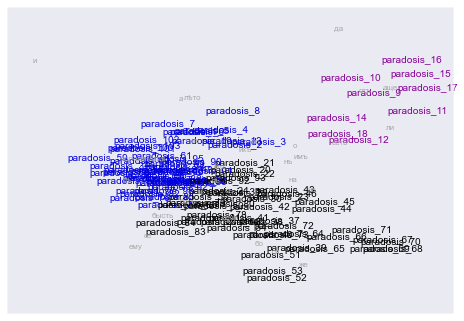

In [13]:
from pystyl.visualization import scatterplot
scatterplot(corpus, coor=pca_coor,
            nb_clusters=3, loadings=pca_loadings,
            save=True, outputfile="/Users/mike/Desktop/pca.pdf")

(I can't make sense of the loadings, because I do not understand this language, but you might.) By changing the `nb_clusters`, we can control how many clusters will being detected and colored (which is just a reading aid). With the parameters in the previous code block, you will also have saved a (more readable version) of this plot to disk. Here we notice the clear separation of samples 12-18 (in purple) from the bulk of the text -- the other samples tend to fall apart in early (blue) and late samples. Likewise, we can also run a traditional cluster analyses on this data. We first import the functions we need and create a pairwise distance matrix, called `dm`, using the `minmax` distance measure.

In [14]:
from pystyl.analysis import distance_matrix
dm = distance_matrix(corpus, 'minmax')

On this distance matrix, we can run a standard clustering algorithm with Ward's linkage method:

In [15]:
from pystyl.analysis import hierarchical_clustering
cluster_tree = hierarchical_clustering(dm, linkage='ward')

We can now visualize and export the resulting dendrogram, as we did with the PCA scatterplot:

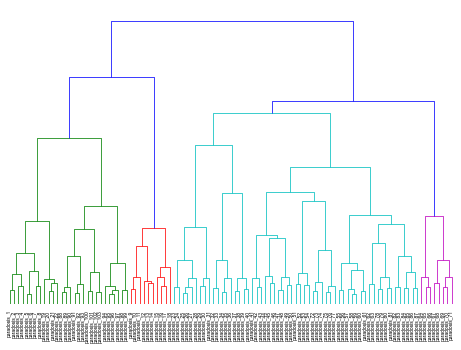

In [16]:
from pystyl.visualization import scipy_dendrogram
scipy_dendrogram(corpus=corpus, tree=cluster_tree,
                 outputfile='~/Desktop/scipy_dendrogram.pdf',
                 fontsize=5, save=True, return_svg=False)

Here, a threefold clustering seems to emerge, distinghuising between three main groups:
- green samples (begin and and of the text?)
- the curious red part with roughly samples 10-120 (cf. PCA results)
- the remainder of the text in blue, with a divergent clade for samples 65-72 (in purple)

A slightly fancier visualization method is to run seaborn's clustermap on our distance matrix, which runs largely parallel:

In [17]:
from pystyl.visualization import clustermap
clustermap(corpus, distance_matrix=dm, fontsize=4, color_leafs=True,\
           outputfile='/Users/mike/Desktop/cm.pdf',
          show=True, save=True, return_svg=False)

OverflowError: ('cannot convert float infinity to integer', u'occurred at index paradosis_1')

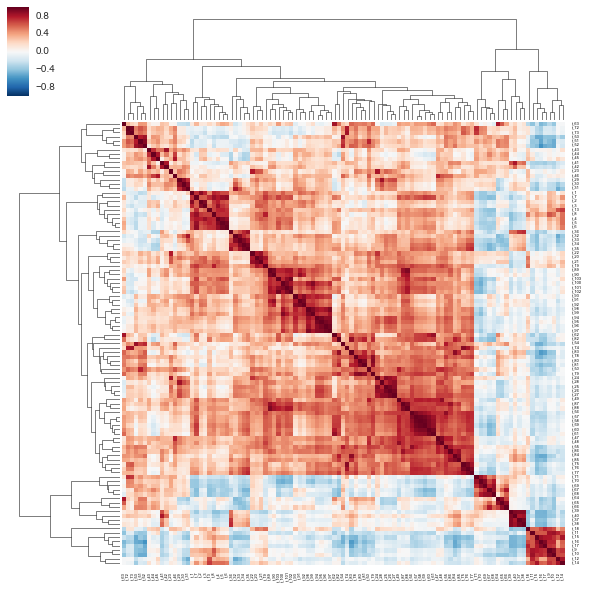

The previous block gives some errors, but yields the correct image in the end, which seems to show a similar structure. Finally, we can now apply the VNC algorithm, which will cluster the data while taking into account (and leave unchanged) the original order of the samples in the text. The setup is again similar: 

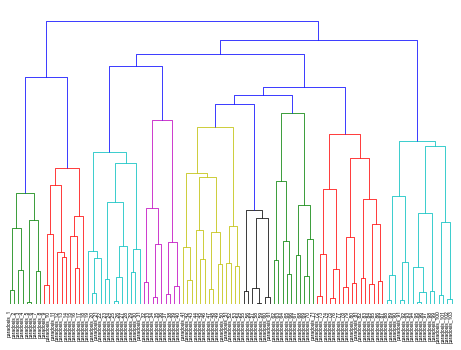

In [18]:
from pystyl.analysis import vnc_clustering
vnc_tree = vnc_clustering(dm, linkage='ward')
scipy_dendrogram(corpus=corpus, tree=vnc_tree,
                 outputfile='~/Desktop/vnc.pdf',\
                 fontsize=5, save=True, return_svg=False)

Voilà. I hope this is helpful.